In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cities = open("cities.txt", "r").read().splitlines()
cities[:8]

['dubai',
 'sharjah',
 'ajman',
 'zaranj',
 'taloqan',
 'shahrak',
 'maymana',
 'kushk']

In [4]:
chars = sorted(list(set("".join(cities))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
import random
random.seed(42)
random.shuffle(cities)

In [6]:
block_size = 8

def build_dataset(cities):
    X, Y = [], []
    for city in cities:
        context = [0] * block_size
        for ch in city + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(.8 * len(cities))
n2 = int(.9 * len(cities))
n1, n2

Xtr, Ytr = build_dataset(cities[:n1])
Xdev, Ydev = build_dataset(cities[n1:n2])
Xte, Yte = build_dataset(cities[n2:])

In [18]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))  / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        # print("batch norm", self.out.shape)
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        # print("tanh shape", self.out.shape)
        return self.out
    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        # print("IX shape", IX.shape)
        # print("embedding weight.shape", self.weight.shape)
        self.out = self.weight[IX]
        # print("weight[IX].shape", self.weight[IX].shape)
        return self.out

    def parameters(self):
        return [self.weight]


class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        
        B, T, C = x.shape
        x = x.view(B, T//self.n , C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        # print("flatten x.shape", x.shape)
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [14]:
torch.manual_seed(12345)

In [43]:
# n_embd = 10
# n_hidden = 68

n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd), ## 27 by 24
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [44]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 19, 16],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  4,  8,  1,  8, 18],
        [ 0,  0,  0, 23,  1, 20, 19, 15]])

In [45]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # emb = C[Xb] ## made into embed module
    # x = emb.view(emb.shape[0], -1) ## made into flatten module
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    # x = Xb
    # for layer in model.layers:
    #     x = layer(x)
    # loss = F.cross_entropy(x, Yb) ## made into Sequential

    # back propogation
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else .01
    for p in parameters:
        p.data += -lr * p.grad
    
    # log tracking
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item()) 

      0 /  200000: 3.2982
  10000 /  200000: 2.2490
  20000 /  200000: 2.3274
  30000 /  200000: 2.4376
  40000 /  200000: 2.0267
  50000 /  200000: 2.3110
  60000 /  200000: 1.4751
  70000 /  200000: 2.4574
  80000 /  200000: 2.1490
  90000 /  200000: 1.8672
 100000 /  200000: 1.8836
 110000 /  200000: 2.1951
 120000 /  200000: 1.8604
 130000 /  200000: 2.2184
 140000 /  200000: 1.9163
 150000 /  200000: 1.6659
 160000 /  200000: 1.7037
 170000 /  200000: 1.3720
 180000 /  200000: 1.7461
 190000 /  200000: 1.3719


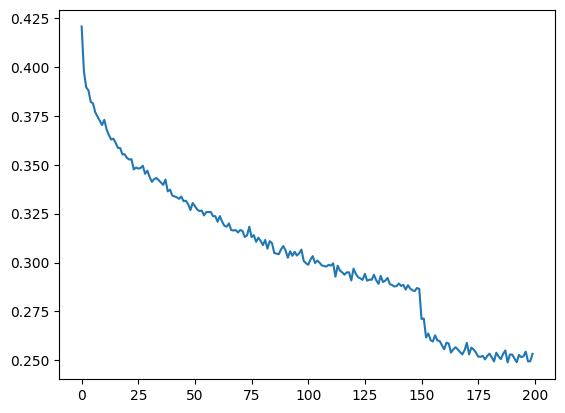

In [47]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [48]:
for layer in  model.layers:
    layer.training = False

In [49]:
@torch.no_grad() # will not call .grad on it, so under the hood doesn't need to be maintained (basically for efficieny)
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")
split_loss("test")

train 1.706324577331543
val 2.5345144271850586
test 2.5674567222595215


_________________________
n_embd: 10, n_hidden: 68
train 2.082386016845703
val 2.371932029724121
test 2.4082465171813965
_________________________
n_embd: 24, n_hidden: 128
train 1.706324577331543
val 2.5345144271850586
test 2.5674567222595215
_________________________

In [55]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

akade.
letgiwaldu.
stanlitsar.
kulenhe.
granjewwooblodal.
savnslayevka.
devgarango.
aschey.
malstede.
pozoya.
grytna.
carbonia.
gumlin.
usehrobingen.
dijkodin.
kandi.
gulussa.
radlin.
azod.
albinondo.
